In [1]:
import SiemensQuadraProperties as sqp
import ExplorerProperties as ep
from ActivityTools import *

In [2]:
from SimulationDataset import *
import matplotlib.pyplot as mpl

In [3]:
# the activity calculation is usually quoted divided by the TOTAL PHANTOM VOLUME
# explorer paper says 22L for 70cm phantom, I say 22.64
# so 1e9 Bq == 44kBq/cc (or ml, since cc==ml)
# from the explorer plots, 16 kBq/cc == 0.36e9 Bq

Simulation complete
347841.0 events loaded (1000000 simulated) with average 1.1461529836908242 hits/event
Simulation complete
107536.0 events loaded (1000000 simulated) with average 1.0075881565243268 hits/event


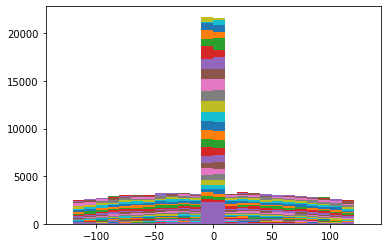

Simulation complete
396061.0 events loaded (1000000 simulated) with average 1.1579201183656054 hits/event
Simulation complete
235458.0 events loaded (1000000 simulated) with average 1.0006752796677114 hits/event


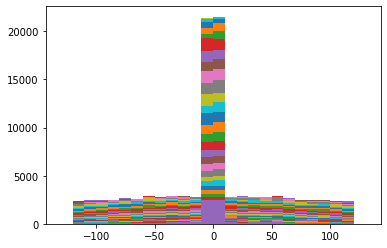

In [4]:
# Include background
def NECRatTimeBetterWithZ( tracerData, crystalData, crystalActivity, detectorRadius, simulationWindow=1E-2, coincidenceWindow=4.7E-9, zWindow=325.0 ):
    
    necrAtTime = []
    trueAtTime = []
    rPlusSAtTime = []
    activityAtTime = []
    hitRadiusHistogram = []
    for time in range( 0, 700, 20 ):
        timeSec = float(time) * 60.0
        activity = F18ActivityAtTime( 1100E6, timeSec )

        necr, true, rPlusS, hitRadii = DetectedCoincidences( [activity, crystalActivity], [tracerData, crystalData], simulationWindow, coincidenceWindow, detectorRadius, ZMin=-zWindow, ZMax=zWindow )
        necrAtTime.append( necr )
        trueAtTime.append( true )
        rPlusSAtTime.append( rPlusS )
        activityAtTime.append( activity )
        y, x, patches = mpl.hist( hitRadii, bins=26, range=[-130,130] )
        hitRadiusHistogram.append( [x, y] )
    
    return activityAtTime, necrAtTime, trueAtTime, rPlusSAtTime, hitRadiusHistogram

tracerData = CreateDataset( 1024, "Siemens", 700, "LinearF18", 1000000, 435.0, 585.0 )
crystalData = CreateDataset( 1024, "Siemens", 1024, "Siemens", 1000000, 435.0, 585.0 )
activityAtTimeSiemens, necrAtTimeSiemens, trueAtTimeSiemens, rPlusSAtTimeSiemens, hitRadiusHistogramSiemens = NECRatTimeBetterWithZ( tracerData, crystalData, sqp.Lu176decaysInMass( sqp.DetectorMass() ), sqp.DetectorRadius() )
mpl.show()

tracerData = CreateDataset( 1850, "Explorer", 700, "LinearF18", 1000000, 430.0, 645.0 )
crystalData = CreateDataset( 1850, "Explorer", 1850, "Explorer", 1000000, 430.0, 645.0 )
activityAtTimeExplorer, necrAtTimeExplorer, trueAtTimeExplorer, rPlusSAtTimeExplorer, hitRadiusHistogramExplorer = NECRatTimeBetterWithZ( tracerData, crystalData, ep.Lu176decaysInMass( ep.DetectorMass() ), ep.DetectorRadius(), coincidenceWindow=4.5E-9 )
mpl.show()

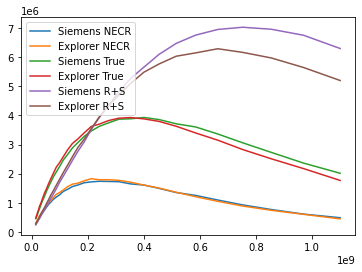

In [5]:
labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrAtTimeSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrAtTimeExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueAtTimeSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueAtTimeExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSAtTimeSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSAtTimeExplorer, label=labels[5] )
mpl.legend( labels )
mpl.show()

In [6]:
# Debug information about the background
print( "Siemens Quadra mass :", sqp.DetectorMass() )
print( "Siemens Quadra background (Bq) :", sqp.Lu176decaysInMass( sqp.DetectorMass() ) )
print( "Explorer mass :", ep.DetectorMass() )
print( "Explorer background (Bq) :", ep.Lu176decaysInMass( ep.DetectorMass() ) )

Siemens Quadra mass : 368574.46400000004
Siemens Quadra background (Bq) : 14726005.989989998
Explorer mass : 552590.79579648
Explorer background (Bq) : 20646468.60786598


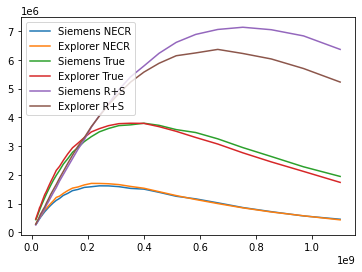

In [9]:
# Closer to the NEMA calculation, hopefully similar results
def necrFromHistogram( inputHistogram, SimulationWindow=1E-2 ):
    
    bins = inputHistogram[0]
    values = inputHistogram[1]
    
    # Assume one bin edge is on the 20mm boundary
    lowValue = 0.0
    lowBin = 0
    highValue = 0.0
    highBin = 0
    histogramTotal = 0.0
    centralTotal = 0.0
    for binIndex in range( len( bins ) - 1 ):
        if bins[binIndex] == -20.0:
            lowValue = ( values[binIndex] + values[binIndex-1] ) / 2.0
            lowBin = binIndex
        elif bins[binIndex] == 20.0:
            highValue = ( values[binIndex] + values[binIndex-1] ) / 2.0
            highBin = binIndex
        
        histogramTotal += values[binIndex]
        if bins[binIndex] >= -20.0 and bins[binIndex] < 20.0:
            centralTotal += values[binIndex]
            
    centralBackground = ( lowValue + highValue ) / 2.0
    centralBackground *= ( highBin - lowBin ) # number of bins in the region
    
    true = centralTotal - centralBackground
    rPlusS = histogramTotal - true
    necr = true * true / histogramTotal
    
    return necr/SimulationWindow, true/SimulationWindow, rPlusS/SimulationWindow

necrFromHistSiemens = []
trueFromHistSiemens = []
rPlusSFromHistSiemens = []
for histogram in hitRadiusHistogramSiemens:
    necr, true, rPlusS = necrFromHistogram( histogram )
    necrFromHistSiemens.append( necr )
    trueFromHistSiemens.append( true )
    rPlusSFromHistSiemens.append( rPlusS )
    
necrFromHistExplorer = []
trueFromHistExplorer = []
rPlusSFromHistExplorer = []
for histogram in hitRadiusHistogramExplorer:
    necr, true, rPlusS = necrFromHistogram( histogram )
    necrFromHistExplorer.append( necr )
    trueFromHistExplorer.append( true )
    rPlusSFromHistExplorer.append( rPlusS )

labels = [ "Siemens NECR", "Explorer NECR", "Siemens True", "Explorer True", "Siemens R+S", "Explorer R+S" ]
mpl.plot( activityAtTimeSiemens, necrFromHistSiemens, label=labels[0] )
mpl.plot( activityAtTimeExplorer, necrFromHistExplorer, label=labels[1] )
mpl.plot( activityAtTimeSiemens, trueFromHistSiemens, label=labels[2] )
mpl.plot( activityAtTimeExplorer, trueFromHistExplorer, label=labels[3] )
mpl.plot( activityAtTimeSiemens, rPlusSFromHistSiemens, label=labels[4] )
mpl.plot( activityAtTimeExplorer, rPlusSFromHistExplorer, label=labels[5] )
mpl.legend( labels )
mpl.show()

In [ ]:
# So the two methods are pretty much the same. Why not use the histograms I guess, saves explanation.